# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cpu'#'cuda:0'
NDIM = 4 # number of parameters
SIGMA = 0.01

In [3]:
# A toy model with a diffuse and point source component

def model(z):
    grid = np.linspace(0, 1, 50, 50)
    X, Y = np.meshgrid(grid, grid)
    x0, y0, r, w = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05
    
    R = ((X-x0)**2 + (Y-y0)**2)**0.5
    
    mu = np.exp(-(R-r)**2/w**2/2)
    x = mu
    return x

In [4]:
def noisemodel(x, z = None, noiselevel = 1.):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

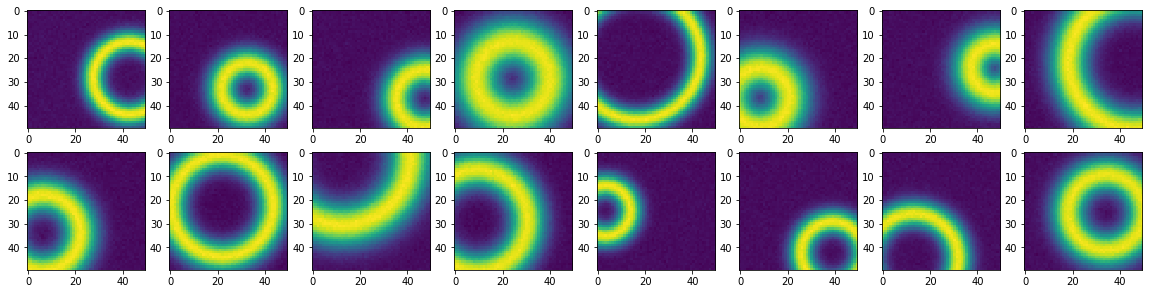

In [5]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z = np.random.rand(5)
    x = model(z)
    x = noisemodel(x)
    plt.imshow(x)

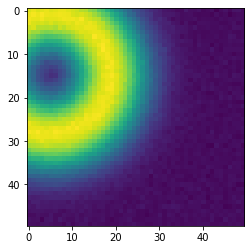

In [6]:
z0 = np.array([0.1, 0.3, 0.2, 0.8])
x0 = noisemodel(model(z0))
plt.imshow(x0)

In [7]:
# Fisher analysis
grad = []

for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[0.00018608 0.0001329  0.00031023 0.00085264]


In [8]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(1, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [9]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
sw.run(nworkers=0, nrounds = 2, max_epochs = 20, early_stopping_patience = 3, nsamples = 2500, nbatch = 32, recycle_net = False, threshold = 1e-8)
%time

Adding samples.: 100%|██████████| 2478/2478 [00:00<00:00, 48361.36it/s]


Adding 2478 new samples.


Extracting samples.: 100%|██████████| 2478/2478 [00:00<00:00, 38740.61it/s]


Extracted 2478 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 19
Validation losses: [9.597033023834229, 8.264992266893387, 7.886383265256882, 7.641267895698547, 7.162793397903442, 6.440790176391602, 6.093538671731949, 6.115399092435837, 5.81705829501152, 5.762872278690338, 5.82339945435524, 5.688928693532944, 5.832584738731384, 5.652899622917175, 5.333716958761215, 5.325314551591873, 5.4664968848228455, 5.6515626311302185, 5.6658928990364075]
LR iteration 1
Total epochs: 6
Validation losses: [4.693299278616905, 4.52289192378521, 4.472211450338364, 4.485817313194275, 4.525878444314003, 4.630217790603638]
LR iteration 2
Total epochs: 4
Validation losses: [4.430048570036888, 4.440943405032158, 4.445461317896843, 4.445001840591431]


Adding samples.: 100%|██████████| 2373/2373 [00:00<00:00, 19445.08it/s]


Adding 2285 new samples.


Extracting samples.: 100%|██████████| 4763/4763 [00:00<00:00, 32100.21it/s]


Extracted 2364 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 15
Validation losses: [7.1859497129917145, 6.228904157876968, 5.310335099697113, 6.135106086730957, 4.775008976459503, 4.412886023521423, 4.2477827072143555, 4.463315337896347, 3.9613486379384995, 4.438823536038399, 3.72242271900177, 3.5938341915607452, 3.7163422405719757, 3.7413910031318665, 4.275108113884926]
LR iteration 1
Total epochs: 16
Validation losses: [2.7903537303209305, 2.5358269438147545, 2.445631004869938, 2.373065061867237, 2.3284707963466644, 2.3290018662810326, 2.3462146259844303, 2.3198945224285126, 2.310830280184746, 2.3005505427718163, 2.3274700045585632, 2.2806482389569283, 2.239107944071293, 2.3169676139950752, 2.3267337940633297, 2.286525946110487]
LR iteration 2
Total epochs: 8
Validation losses: [2.2137391790747643, 2.1775075308978558, 2.173948500305414, 2.178995940834284, 2.1494688149541616, 2.2051512971520424, 2.1887790206819773, 2.152543757110834]
CPU times: use

In [25]:
sw.run(nworkers=0, nrounds = 2, max_epochs = 20, early_stopping_patience = 1, nsamples = 2500, nbatch = 32, recycle_net = False, threshold = 1e-8)

Adding samples.: 100%|██████████| 2443/2443 [00:00<00:00, 22920.26it/s]


Adding 2443 new samples.


Extracting samples.: 100%|██████████| 7206/7206 [00:00<00:00, 31973.93it/s]


Extracted 2446 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 5
Validation losses: [8.82528617978096, 6.2622577250003815, 5.995348274707794, 5.1634145975112915, 6.094657897949219]
LR iteration 1
Total epochs: 7
Validation losses: [3.428618088364601, 2.9686175882816315, 2.6918645948171616, 2.527348294854164, 2.3589410334825516, 2.225424148142338, 2.380683980882168]
LR iteration 2
Total epochs: 2
Validation losses: [2.0685567557811737, 2.0790064595639706]


Adding samples.: 100%|██████████| 2423/2423 [00:00<00:00, 19446.98it/s]


Adding 2382 new samples.


Extracting samples.: 100%|██████████| 9588/9588 [00:00<00:00, 29562.47it/s]


Extracted 2421 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 3
Validation losses: [9.67161351442337, 8.92792272567749, 9.183338344097137]
LR iteration 1
Total epochs: 6
Validation losses: [6.73597252368927, 5.629876226186752, 4.9811268746852875, 4.729487583041191, 4.027216210961342, 4.2164625227451324]
LR iteration 2
Total epochs: 10
Validation losses: [3.6820511370897293, 3.6464187651872635, 3.621354714035988, 3.6204093247652054, 3.504795327782631, 3.4377116560935974, 3.4356449246406555, 3.427658274769783, 3.3607756942510605, 3.4532024413347244]


2.243581777274114 5.152832987758295
4.1432933634551405 9.57048870881552
2.6096685729934985 6.098229469552911
1.6854130574987167 4.021885791622029


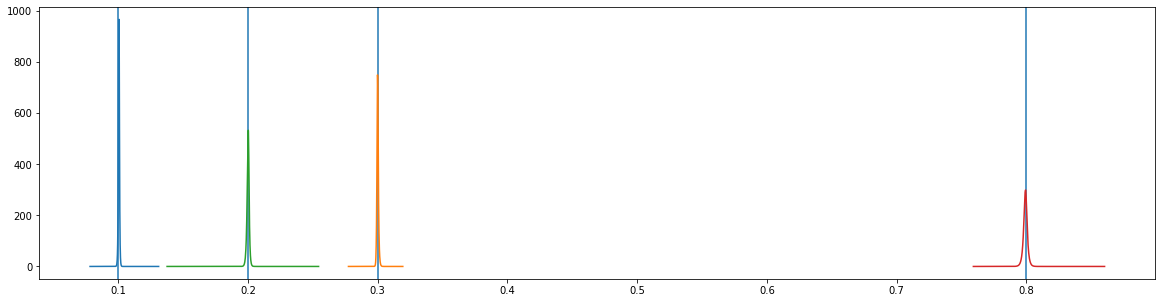

In [27]:
plt.figure(figsize=(20, 5))
for i in range(4):
    z, p = sw.posterior(i, version = -2)
    plt.axvline(z0[i])
    #plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])
#plt.xlim([0.79, 0.81])

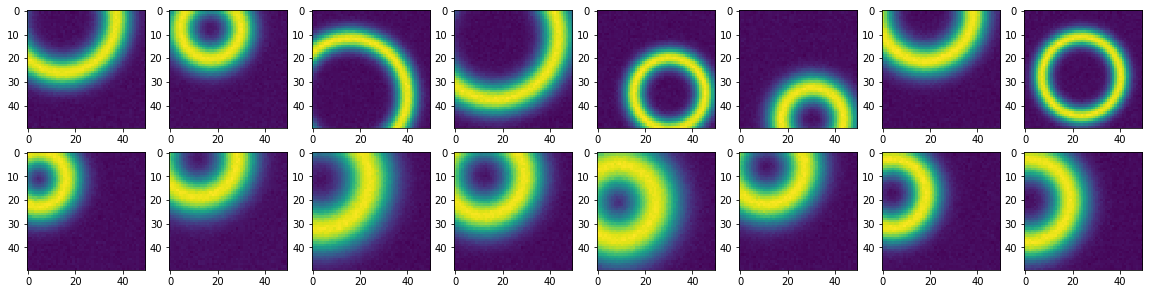

In [24]:
# Training data in different rounds (without noise)

plt.figure(figsize=(20, 10))
counter = 0
for r in range(2):
    imgs = swyft.get_x(sw.data_store[r])
    for i in range(8):
        counter += 1
        plt.subplot(4, 8, counter)
        plt.imshow(imgs[i])